#**Factors affecting US home prices**


### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv('/homellc.csv')

In [3]:
data.head()

,Date,employees,GDP,monthly_supply,Population,mortgage_rate,deliquency_rate,Cpi,new_permits,target_house_price,total_construction_spending
0,2004-04-01,131409.0,12112.815,4.0,293103.0,5.52,15518.454,186.3,4399.736034,145.058,967602.0
1,2004-05-01,131693.0,12305.307,3.8,293350.0,5.79,14663.15,186.7,4671.297875,146.592,974381.0
2,2004-06-01,131789.0,12527.214,3.9,293603.0,5.89,15585.007,187.1,5153.018842,148.185,983087.0
3,2004-07-01,131850.0,12767.286,4.5,293857.0,5.94,16038.281,187.4,4963.832566,149.850,1006184.0
4,2004-08-01,131936.0,12922.656,4.3,294104.0,6.01,14750.352,188.2,4937.878663,151.337,1013616.0


### Data Preprocessing

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

data['deliquency_rate'] = pd.to_numeric(data['deliquency_rate'], errors='coerce')

missing_values = data.isnull().sum()

missing_values

Date                           803
employees                      803
GDP                            803
monthly_supply                 803
Population                     803
mortgage_rate                    0
deliquency_rate                 12
Cpi                            800
new_permits                    803
target_house_price             803
total_construction_spending    803
dtype: int64

### Exploratory Data Analysis


In [5]:

data_clean = data.dropna(subset=['Date'])

remaining_missing_values = data_clean.isnull().sum()

data_clean.describe(), remaining_missing_values

(                                Date      employees  monthly_supply  \
 count                            241     241.000000      241.000000   
 mean   2014-04-01 11:45:03.734439936  140907.410788        6.409544   
 min              2004-04-01 00:00:00  129702.000000        3.300000   
 25%              2009-04-01 00:00:00  134297.000000        5.000000   
 50%              2014-04-01 00:00:00  138298.000000        5.800000   
 75%              2019-04-01 00:00:00  147375.000000        7.700000   
 max              2024-04-01 00:00:00  158271.000000       12.200000   
 std                              NaN    7950.321728        1.918689   
 
           Population  mortgage_rate  deliquency_rate         Cpi  \
 count     241.000000     241.000000       239.000000  241.000000   
 mean   318042.763485       6.138714     60431.341280  236.363606   
 min    293103.000000       5.480000     14663.150000  186.300000   
 25%    307090.000000       5.850000     33319.998000  214.790000   
 50% 

<ipython-input-6-25423154e57f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['deliquency_rate'].fillna(data_clean['deliquency_rate'].mean(), inplace=True)


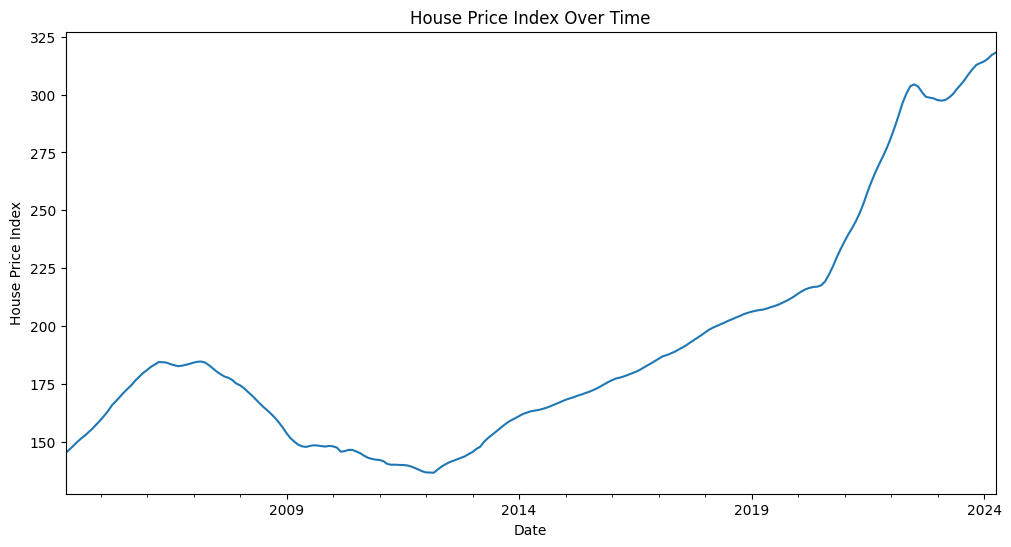

In [6]:

data_clean['deliquency_rate'].fillna(data_clean['deliquency_rate'].mean(), inplace=True)


data_clean.set_index('Date', inplace=True)


data_clean['target_house_price'].plot(figsize=(12, 6), title='House Price Index Over Time')
plt.ylabel('House Price Index')
plt.show()


In [7]:
data_clean.dtypes


employees                      float64
GDP                             object
monthly_supply                 float64
Population                     float64
mortgage_rate                  float64
deliquency_rate                float64
Cpi                            float64
new_permits                    float64
target_house_price             float64
total_construction_spending    float64
dtype: object

In [8]:
data_clean['GDP'] = pd.to_numeric(data_clean['GDP'], errors='coerce')
data_clean['GDP'].fillna(data_clean['GDP'].mean(), inplace=True)

<ipython-input-8-4ea8a223d6f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['GDP'] = pd.to_numeric(data_clean['GDP'], errors='coerce')
<ipython-input-8-4ea8a223d6f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['GDP'].fillna(data_clean['GDP'].mean(), inplace=True)


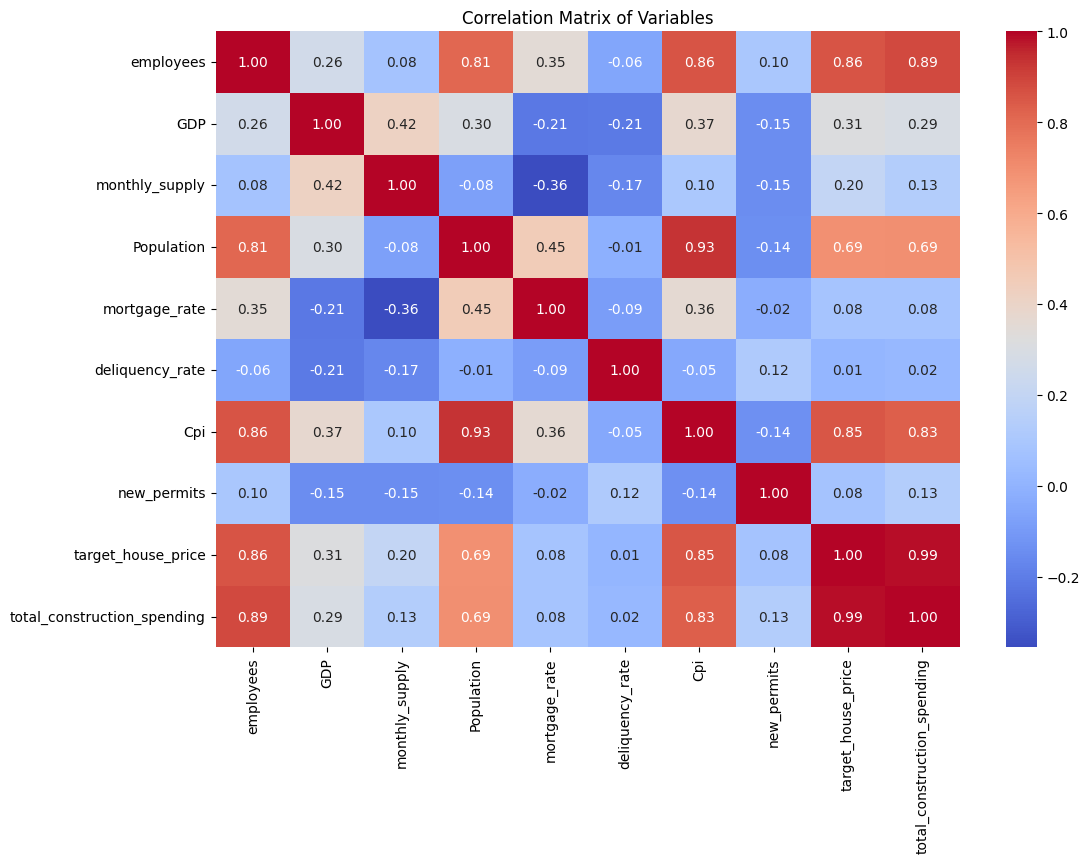

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


### Scaling and Train-Test Split

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = data_clean.drop('target_house_price', axis=1)
y = data_clean['target_house_price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((192, 9), (49, 9), (192,), (49,))

### Evaluating Regression Models

In [11]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, LinearRegression, ElasticNet
import numpy as np

models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "BayesianRidge": BayesianRidge(),
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet()
}

results = {}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    results[name] = scores

for name, scores in results.items():
    print(f'{name}: Mean MAE: {np.mean(scores):.3f} ({np.std(scores):.3f})')


Lasso: Mean MAE: 5.979 (0.992)
Ridge: Mean MAE: 4.698 (0.847)
BayesianRidge: Mean MAE: 4.642 (0.880)
LinearRegression: Mean MAE: 4.640 (0.886)
ElasticNet: Mean MAE: 12.915 (2.235)


### Hyper-Parameter Selection

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import BayesianRidge

model_br = BayesianRidge()
parameters = {
    'alpha_1': list(range(0, 10)),
    'alpha_2': list(range(0, 10)),
    'lambda_1': list(range(0, 10)),
    'lambda_2': list(range(0, 10))
}
clf = GridSearchCV(model_br, parameters, cv=5)
clf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=BayesianRidge(),
             param_grid={'alpha_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'alpha_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]})

### Model Fitting

In [13]:
best_params = clf.best_params_
model_br = BayesianRidge(**best_params)
model_br.fit(X_train, y_train)
predictions = model_br.predict(X_test)


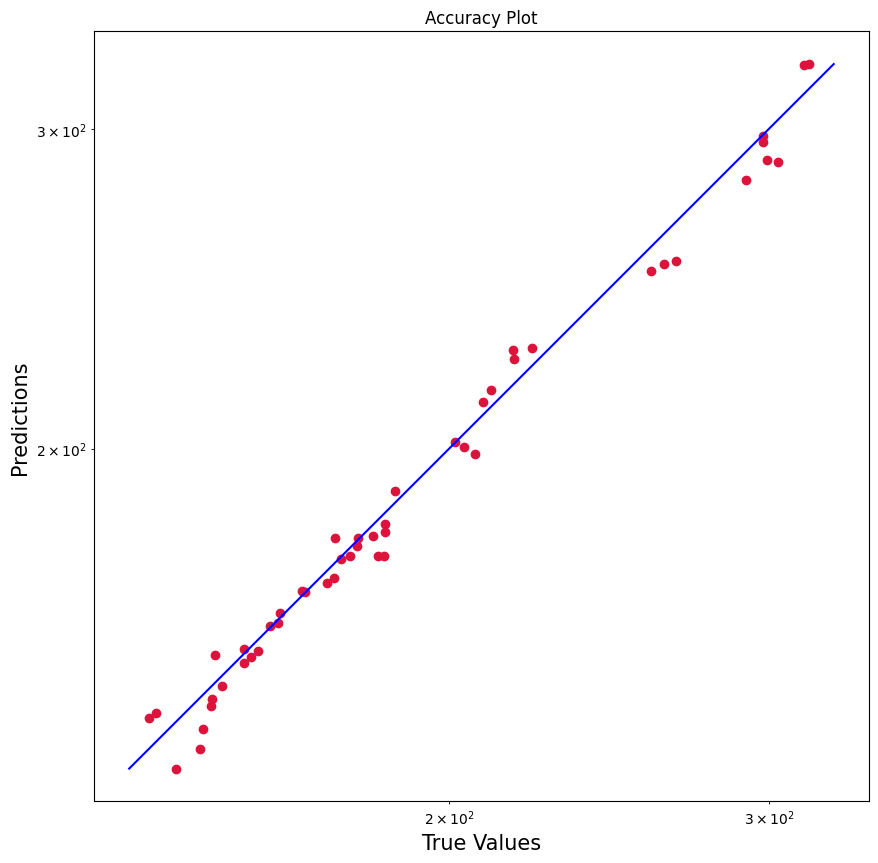

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Accuracy Plot")
plt.axis('equal')
plt.show()


### Bias-Variance Check


In [15]:
from mlxtend.evaluate import bias_variance_decomp
X_train_np = np.array(X_train, dtype='float32')
X_test_np = np.array(X_test, dtype='float32')
y_train_np = np.array(y_train, dtype='float32')
y_test_np = np.array(y_test, dtype='float32')

mse, bias, variance = bias_variance_decomp(
    model_br, X_train_np, y_train_np, X_test_np, y_test_np, loss='mse', num_rounds=200, random_seed=123
)
print("Average Bias: ", bias)
print("Average Variance: ", variance)


Average Bias:  38.439228699716786
Average Variance:  2.493984666135057


### Error Analysis


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


RMSE: 6.207104575955101
R2 Score: 0.9860692614349493


In [17]:
r_squared_percentage = r2 * 100
print(f"Accuracy: {r_squared_percentage:.2f}%")


Accuracy: 98.61%


### OLS


In [18]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:     target_house_price   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1483.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          3.47e-165
Time:                        21:25:08   Log-Likelihood:                -605.06
No. Observations:                 192   AIC:                             1230.
Df Residuals:                     182   BIC:                             1263.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.9235      0.421    453.901      0.0